# Project 4 - Customer Segmentation and Recommendation

Project Source: https://www.kaggle.com/code/farzadnekouei/customer-segmentation-recommendation-system

In this project, we explore retail transactional data, transform to customer-centric features, segment the customers and make campaign recommendations for marketing teams and product recommendations to customers to boost the sales of the business.

In [1]:
# Import the required libraries and dependencies

import numpy as np
import pandas as pd
from pathlib import Path
import time, warnings
import datetime as dt
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
%matplotlib inline
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")
import io

In [2]:
# Read the excel file (with transactional data) into pandas data frame. Please note: It takes few seconds to load, due to high volume of data

retail_df = pd.read_excel(Path("../Resources/Online_Retail.xlsx"))
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
# Check the number of rows/columns
retail_df.shape

(541909, 8)

In [4]:
# Remove negative quantity and missing CustomerID rows
retail_df = retail_df[retail_df['Quantity']>0]
retail_df.dropna(subset=['CustomerID'],how='all',inplace=True)

# Convert CustomerID to an integer
retail_df['CustomerID']=retail_df['CustomerID'].astype(int)
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [5]:
# Check the number of rows/columns
retail_df.shape

(397924, 8)

# Feature Engineering and Data Transformation



In order to create a comprehensive customer-centric dataset for clustering and recommendation, the following features can be engineered from the available transactional data.

RFM Features

RFM is a method used for analyzing customer value and segmenting the customer base. It is an acronym that stands for:

Recency (R): This metric indicates how recently a customer has made a purchase. A lower recency value means the customer has purchased more recently, indicating higher engagement with the brand.

Frequency (F): This metric signifies how often a customer makes a purchase within a certain period. A higher frequency value indicates a customer who interacts with the business more often, suggesting higher loyalty or satisfaction.

Monetary (M): This metric represents the total amount of money a customer has spent over a certain period. Customers who have a higher monetary value have contributed more to the business, indicating their potential high lifetime value.

Together, these metrics help in understanding a customer's buying behavior and preferences, which is pivotal in personalizing marketing strategies and creating a recommendation system.

**Recency**

In [6]:
# Create Recency data frame

# Latest Invoice date (most recent) from the data set
retail_df['date'] = pd.DatetimeIndex(retail_df['InvoiceDate']).date
most_recent = retail_df['date'].max()

# Grouping data by 'CustomerID' and finding most recent purchase date for each customer
recency = retail_df.groupby(by='CustomerID', as_index=False)['date'].max()
recency.columns = ['CustomerID','LastPurchaseDate']

# 'Recency' = 'most_recent' - 'LastPurchaseDate'. This shows how many days since last purchase.
recency['Recency'] = recency['LastPurchaseDate'].apply(lambda x: (most_recent - x).days)
recency.head()

,CustomerID,LastPurchaseDate,Recency
0,12346,2011-01-18,325
1,12347,2011-12-07,2
2,12348,2011-09-25,75
3,12349,2011-11-21,18
4,12350,2011-02-02,310


In [7]:
# Drop the LastPurchaseDate column from the recency data frame
recency.drop('LastPurchaseDate',axis=1,inplace=True)

In [8]:
recency.head()

,CustomerID,Recency
0,12346,325
1,12347,2
2,12348,75
3,12349,18
4,12350,310


**Frequency**

In [9]:
# Remove duplicate invoice number rows for each customer
retail_df_copy = retail_df
retail_df_copy.drop_duplicates(subset=['InvoiceNo', 'CustomerID'], keep="first", inplace=True)

# Counting number of unique 'InvoiceNo' for each customer
frequency = retail_df_copy.groupby(by=['CustomerID'], as_index=False)['InvoiceNo'].count()
frequency.columns = ['CustomerID','Frequency']
frequency.head()

,CustomerID,Frequency
0,12346,1
1,12347,7
2,12348,4
3,12349,1
4,12350,1


**Monetary**

In [10]:
# Calculate monetory value for each customer

retail_df['TotalCost'] = retail_df['Quantity'] * retail_df['UnitPrice']

#summing the 'TotalCost' for each customer
monetary = retail_df.groupby(by='CustomerID',as_index=False).agg({'TotalCost': 'sum'})
monetary.columns = ['CustomerID','Monetary']
monetary.head()

,CustomerID,Monetary
0,12346,77183.60
1,12347,163.16
2,12348,331.36
3,12349,15.00
4,12350,25.20


**RFM Table**

In [11]:
# Merge Recency, Frequency and Monetary data frames to create RFM data frame

temp = recency.merge(frequency,on='CustomerID')
rfm= temp.merge(monetary,on='CustomerID')

rfm.set_index('CustomerID',inplace=True)
rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346,325,1,77183.60
12347,2,7,163.16
12348,75,4,331.36
12349,18,1,15.00
12350,310,1,25.20


In [12]:
rfm.shape[0]

4339

#### Data Analysis and processing of RFM data frame 

In [13]:
# Counting duplicate rows in RFM table (The values of rows (recency, frequency and monetary together), being same)
duplicate_count = rfm.duplicated().sum()
print("Number of duplicate rows:", duplicate_count)

Number of duplicate rows: 58


In [14]:
# Drop duplicate rows from RFM table
rfm.drop_duplicates(inplace=True)

# Verify for duplicates if any left
duplicate_count_new = rfm.duplicated().sum()
print("Number of duplicate rows:", duplicate_count_new)

Number of duplicate rows: 0


In [15]:
# Verify for null values in RFM table

print(rfm.isnull().sum())

Recency      0
Frequency    0
Monetary     0
dtype: int64


In [16]:
rfm.shape

(4281, 3)

In [17]:
# Describe RFM statistics
rfm.describe()

,Recency,Frequency,Monetary
count,4281.000000,4281.000000,4281.000000
mean,91.407849,4.315814,300.555732
std,99.460322,7.748214,3149.247340
min,0.000000,1.000000,0.000000
25%,17.000000,1.000000,17.850000
50%,50.000000,2.000000,48.300000
75%,141.000000,5.000000,132.650000
max,373.000000,210.000000,168471.250000


Text(0.5, 1.0, 'Outliers Variable Distribution')

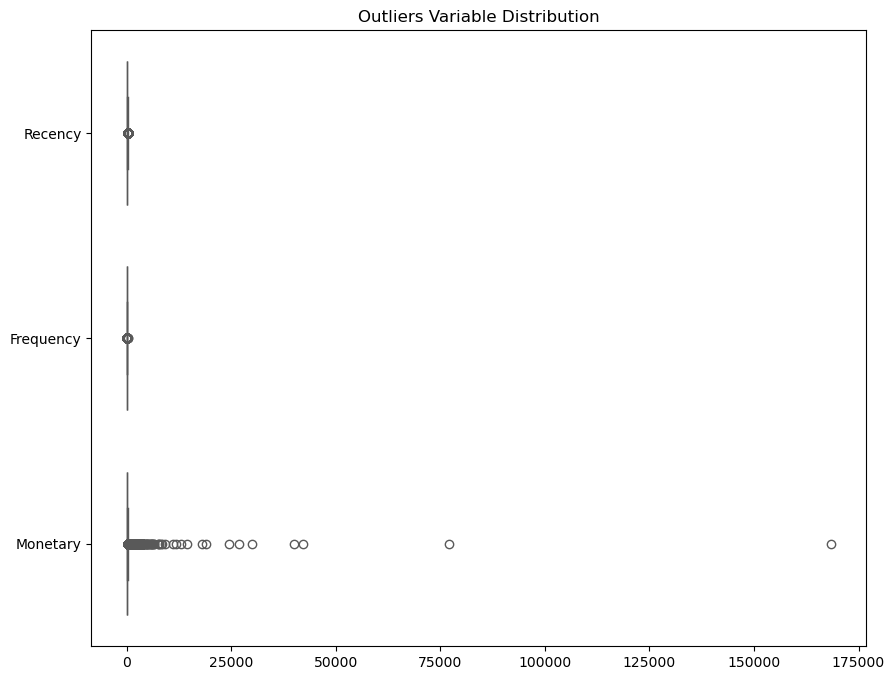

In [18]:
#Boxplot to see outliers
attributes = ['Recency', 'Frequency', 'Monetary']

plt.figure(figsize=(10, 8))

sns.boxplot(data = rfm[attributes], orient="h", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 12)

In [19]:
# Removing outliers
attributes = ['Recency', 'Frequency', 'Monetary']

for attribute in attributes:
    # Calculate quartiles and IQR
    Q1 = rfm[attribute].quantile(0.05)
    Q3 = rfm[attribute].quantile(0.95)
    IQR = Q3 - Q1

    # Remove outliers
    rfm = rfm[(rfm[attribute] >= Q1 - 1.5*IQR) & (rfm[attribute] <= Q3 + 1.5*IQR)]

In [20]:
# The rows/columns of the 'rfm' data frame, after removing outliers
rfm.shape

(4162, 3)

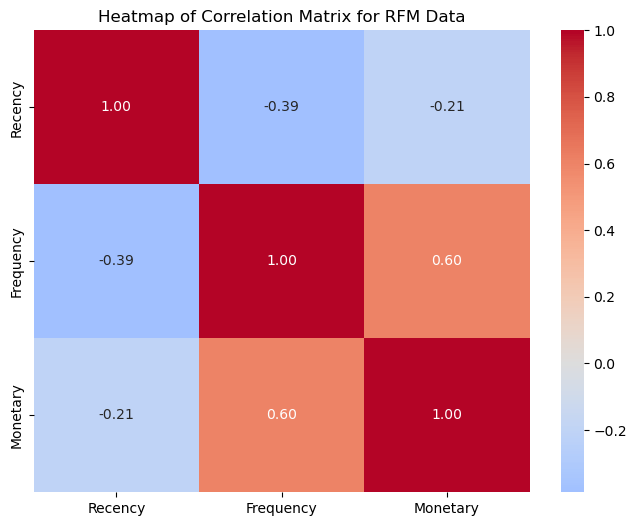

In [21]:
# Heatmap to see the RFM variables correlation

plt.figure(figsize=(8, 6))
sns.heatmap(rfm.corr(), annot=True, center=0, cmap='coolwarm', fmt=".2f")
# sns.heatmap(rfm.corr(), annot=True, center=0, cmap='coolwarm', fmt=".2f",linewidths=2, vmin = -1, vmax = 1)
plt.title('Heatmap of Correlation Matrix for RFM Data')
plt.show()

It looks like Frequency and Monetary are correlated. So, PCA is a good tool to address this, but both PCA and KMeans Clustering can be skewed with the unscaled data. So we will scale the data in the next steps.

In [22]:
# Create a data frame with the cleaned RFM data
rfm_cluster = pd.DataFrame(data=rfm)

### Feature Scaling

In [23]:
# Standardize the features

rfm_cluster_scaled = StandardScaler().fit_transform(rfm_cluster)


In [24]:
rfm_cluster_scaled

array([[-0.91309705,  0.86940432,  0.28827128],
       [-0.18141626,  0.09540201,  1.21894139],
       [-0.75272865, -0.67860029, -0.53151519],
       ...,
       [-0.86298192, -0.42059952, -0.40287024],
       [-0.90307402,  3.19141125, -0.24517644],
       [-0.51217607, -0.16259875, -0.1696494 ]])

# PCA / K-means Clustering

Applying PCA with 2 dimensions

In [25]:
# Instantiate PCA
pca = PCA(n_components=2)

# Fit PCA to features
principal_components = pca.fit_transform(rfm_cluster_scaled)


In [26]:
# Calculate the PCA explained variance ratio
pca.explained_variance_ratio_

array([0.60563992, 0.27198328])

About 87% of variance is captured by the two PCA variables.

In [27]:
# Create a DataFrame with the principal components
pca_df = pd.DataFrame(data=principal_components, columns=['PCA1', 'PCA2'])
pca_df.head()

,PCA1,PCA2
0,1.163553,-0.512843
1,0.874431,0.476671
2,-0.416147,-1.002388
3,-1.730850,1.517209
4,2.409353,0.859212


Determine optimal number of K using PCA data frame and utilizing Elbow Method


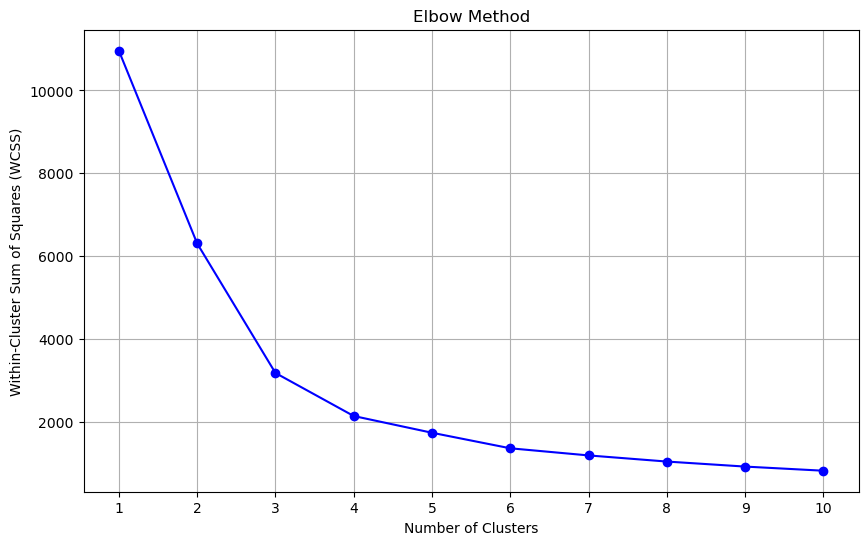

In [28]:
# Create a a list to store inertia values and the values of k
wcss = []

# Create a for-loop where each value of k is evaluated using the K-means algorithm
# Fit the model using the PCA DataFrame
# Append the value of the computed inertia from the `inertia_` attribute of the KMeans model instance

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(pca_df)
    wcss.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='-', color='b')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

The elbow appears to be at the point 5, after which the inertia starts decreasing linearly. So, the optimal K=5.

KMeans Clustering

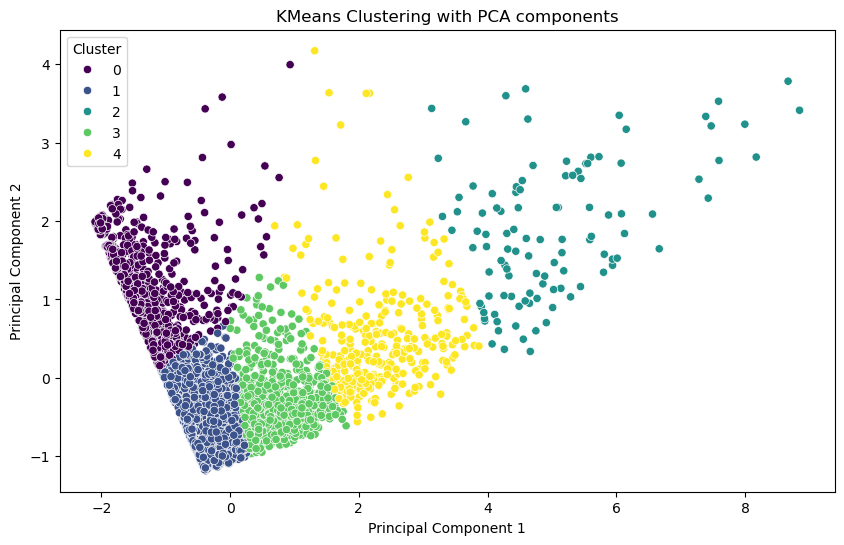

In [29]:
# Segment the PCA data frame using KMeans algorithm
kmeans = KMeans(n_clusters=5)
kmeans.fit(pca_df)

# Add column 'Cluster' to the pca_df, with cluster labels
pca_df['Cluster'] = kmeans.labels_

#Plot PCA Clustering
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Cluster', palette='viridis')
plt.title('KMeans Clustering with PCA components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [30]:
pca_df.head()

,PCA1,PCA2,Cluster
0,1.163553,-0.512843,3
1,0.874431,0.476671,3
2,-0.416147,-1.002388,1
3,-1.730850,1.517209,0
4,2.409353,0.859212,4


In [31]:
# Calculate mean values for each cluster
rfm_cluster['Cluster'] = kmeans.labels_
cluster_means = rfm_cluster.groupby('Cluster').mean()

print("Mean values for each cluster:")
print(cluster_means)

Mean values for each cluster:
            Recency  Frequency    Monetary
Cluster                                   
0        253.176471   1.468524   48.760268
1         54.860920   2.004759   38.146372
2         17.458716  16.816514  847.333303
3         30.068886   5.564868  142.692319
4         32.046584   9.984472  391.947050


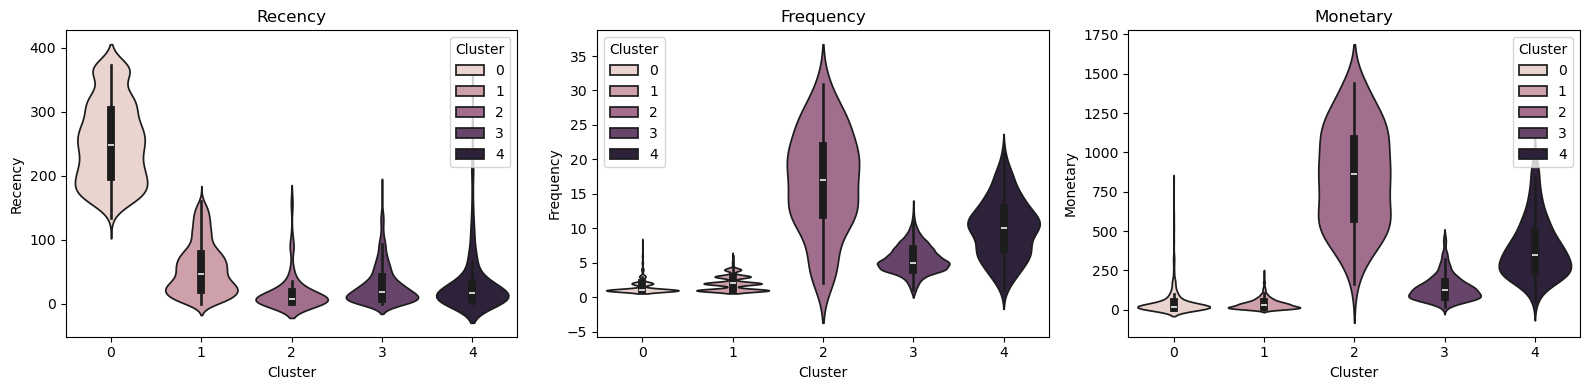

In [32]:
# Plot the RFM mean values among the clusters

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Create catplot 'Recency'
sns.violinplot(data=rfm_cluster, x="Cluster", y="Recency", hue="Cluster", ax=axes[0])
axes[0].set_title('Recency')

# Create catplot 'Frequency'
sns.violinplot(data=rfm_cluster, x="Cluster", y="Frequency", hue="Cluster", ax=axes[1])
axes[1].set_title('Frequency')

# Create catplot 'Monetary'
sns.violinplot(data=rfm_cluster, x="Cluster", y="Monetary", hue="Cluster", ax=axes[2])
axes[2].set_title('Monetary')

plt.tight_layout()
plt.show()

* Cluster 0: **Frequent Shoppers**
Recency: 30.15, Frequency: 5.70, Monetary: 148.25.
Customers who shop frequently with moderate to High spending. They engage often and spend moderately.

* Cluster 1: **Occasional Shoppers**
Recency: 54.15, Frequency: 2.04, Monetary: 39.10.
Customers with recent but infrequent purchases and low spending.

* Cluster 2: **Inactive Shoppers**
Recency: 252.71, Frequency: 1.47, Monetary: 49.27.
Customers who haven't been active for an extended period, with no recent purchases.

* Cluster 3: **Regular Shoppers**
Recency: 31.32, Frequency: 10.19, Monetary: 398.47.
Customers who shop regularly, with recent purchases. Moderate frequency and  moderate spending.

* Cluster 4 : **High-Value Loyal Shoppers**
Recency: 17.60, Frequency: 16.78, Monetary: 852.17.
VIP Customers who shop very often and spend significantly.They engage frequently and spend generously.

PLEASE NOTE: Every time the script is run, the above values can change with clusters, which is the KMeans algorithm behaviour, as the starting points of centroids is different each time.  

In [33]:
rfm['Cluster'] = kmeans.labels_

In [34]:
# Assign segment names for each cluster. Note: This is based on the mean values obtained in the previous step. It can vary each time it is run.

segment_names = {
    0: 'Frequent Shoppers',
    1: 'Occasional Shoppers',
    2: 'Inactive Shoppers',
    3: 'Regular Shoppers',
    4: 'High-Value Loyal Shoppers' }

# Map the cluster values to segment names
rfm['Segment'] = rfm['Cluster'].map(segment_names)
print(rfm)

            Recency  Frequency  Monetary  Cluster                    Segment
CustomerID                                                                  
12347             2          7    163.16        3           Regular Shoppers
12348            75          4    331.36        3           Regular Shoppers
12349            18          1     15.00        1        Occasional Shoppers
12350           310          1     25.20        0          Frequent Shoppers
12352            36          8    536.30        4  High-Value Loyal Shoppers
...             ...        ...       ...      ...                        ...
18280           277          1     23.70        0          Frequent Shoppers
18281           180          1      5.04        0          Frequent Shoppers
18282             7          2     38.25        1        Occasional Shoppers
18283             3         16     66.75        4  High-Value Loyal Shoppers
18287            42          3     80.40        1        Occasional Shoppers

* Let’s visualize the distribution of the different clusters using a donut chart:

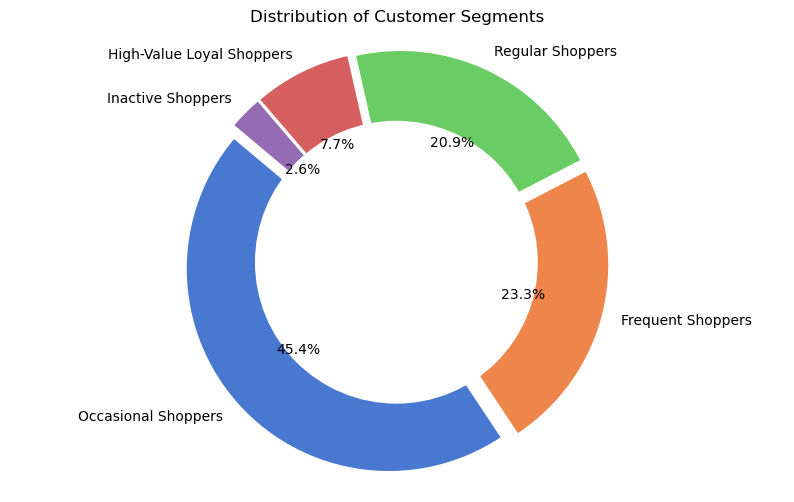

In [35]:
# Plot the segments distribution

segment_counts = rfm['Segment'].value_counts()

# Legend
legend_labels = [f'{segment} ({count})' for segment, count in segment_counts.items()]

plt.figure(figsize=(10, 6))
explode = (0.05, 0.05, 0.05, 0.05, 0.05)

# Pie Chart
plt.pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('muted', len(segment_counts)),explode=explode)
plt.title('Distribution of Customer Segments')
plt.axis('equal')

# Draw circle
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()

# Adding Circle in Pie chart
fig.gca().add_artist(centre_circle)

plt.show()

In [36]:
# Export Customer segments to an excel file

rfm.to_csv("Customer_Segments.csv")

### Recommendation for Marketing Campaign

Here are some examples of how we can tailor marketing efforts—to target customers in each segment—to enhance customer engagement and retention:

**For High Value/Loyal Customers**: Offer personalized special discounts, early access, and other premium perks to make them feel valued and appreciated.

**For Frequent/Regular Customers**: Appreciation campaigns, referral bonuses, and rewards for loyalty.

**For Occasional Customers**: Re-engagement efforts that include running discounts or promotions to encourage buying.

**For Inactive Customers**: Targeted campaigns educating them about the brand and discounts on subsequent purchases.



### Recommendation of Products for each customer

Using the above segmentations, we can make products recommendation to customers. Here are the steps to implement that:

1. Identify which customerIDs belong in each cluster.
2. Add the cluster ID to each transaction.
2. Find top selling products grouped by cluster.
3. For each customer, determine which top selling products in their cluster that they have not purchased.



Match CustomerIDs with clusters

In [37]:
cluster = pd.Series(kmeans.labels_, index=rfm.index, name='Cluster')
cluster.value_counts()

Cluster
1    1891
0     969
3     871
4     322
2     109
Name: count, dtype: int64

Cluster ID mapping to each Transaction

In [38]:
# Add cluster data to the original trasaction data and create a data frame for recommendations

rec_df = pd.merge(left=retail_df, right=rfm, how='inner', # only keep rows if we have a cluster associated with the customer id
                  on='CustomerID')

rec_df.groupby('Cluster').head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,date,TotalCost,Recency,Frequency,Monetary,Cluster,Segment
0,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047,United Kingdom,2010-12-01,54.08,31,10,203.53,4,High-Value Loyal Shoppers
1,536368,22960,JAM MAKING SET WITH JARS,6,2010-12-01 08:34:00,4.25,13047,United Kingdom,2010-12-01,25.50,31,10,203.53,4,High-Value Loyal Shoppers
2,536369,21756,BATH BUILDING BLOCK WORD,3,2010-12-01 08:35:00,5.95,13047,United Kingdom,2010-12-01,17.85,31,10,203.53,4,High-Value Loyal Shoppers
3,543113,16161P,WRAP ENGLISH ROSE,25,2011-02-03 13:06:00,0.42,13047,United Kingdom,2011-02-03,10.50,31,10,203.53,4,High-Value Loyal Shoppers
4,548331,22960,JAM MAKING SET WITH JARS,6,2011-03-30 13:28:00,4.25,13047,United Kingdom,2011-03-30,25.50,31,10,203.53,4,High-Value Loyal Shoppers
10,536370,22728,ALARM CLOCK BAKELIKE PINK,24,2010-12-01 08:45:00,3.75,12583,France,2010-12-01,90.00,2,15,617.80,2,Inactive Shoppers
11,540455,21086,SET/6 RED SPOTTY PAPER CUPS,12,2011-01-07 12:07:00,0.65,12583,France,2011-01-07,7.80,2,15,617.80,2,Inactive Shoppers
12,543625,22540,MINI JIGSAW CIRCUS PARADE,72,2011-02-10 15:38:00,0.42,12583,France,2011-02-10,30.24,2,15,617.80,2,Inactive Shoppers
13,546373,23007,SPACEBOY BABY GIFT SET,6,2011-03-11 12:00:00,14.95,12583,France,2011-03-11,89.70,2,15,617.80,2,Inactive Shoppers
14,554134,23280,FOLDING BUTTERFLY MIRROR HOT PINK,24,2011-05-23 09:48:00,0.83,12583,France,2011-05-23,19.92,2,15,617.80,2,Inactive Shoppers


Top selling products by Cluster

In [39]:
# Group products by cluster and find total quantity of each stock code sold
top_products = rec_df.groupby(['Cluster', 'StockCode'])['Quantity'].sum().reset_index()
# Sort data by cluster, then by total quantity sold, with higher quantities at the top
top_products = (top_products.sort_values(['Cluster', 'Quantity'], ascending=[True, False])
                # Group sales by cluster
                .groupby('Cluster'))
top_products.head(3) 

,Cluster,StockCode,Quantity
658,0,84077,3456
664,0,84568,1728
732,0,75049L,864
2121,1,84826,12540
810,1,16045,1700
1449,1,22578,495
2331,2,16014,3500
2861,2,23084,2430
2551,2,22151,1776
3209,3,17096,2019


Determination of products recommendation to each customer

In [40]:
# Create a dictionary of columns needed for recommendation
recs = {'CustomerID': [],
        'Cluster': [],
        'StockCode0': [],
        'StockCode1': [],
        'StockCode2': []}

# group purchases by customer so we don't need to do this inside the loop
customer_purchases = rec_df.groupby('CustomerID')

for id in cluster.index:
    recs['CustomerID'].append(id)
    this_cluster = cluster.loc[id]
    recs['Cluster'].append(this_cluster)
    # get the stock codes this customer has purchased
    purchases = customer_purchases.get_group(id)['StockCode'].drop_duplicates()
    # get top selling products for this cluster
    cluster_products = top_products.get_group(this_cluster).iloc[:10,:]
    # find top selling products that the customer has not purchased
    suggested_products = cluster_products[~cluster_products['StockCode'].isin(purchases)].reset_index()
    # Handle cases where customer has purchased almost all of the recommended products
    for i in range(3):
        try:
            recs[f'StockCode{i}'].append(suggested_products.loc[i,'StockCode'])
        except KeyError:
            recs[f'StockCode{i}'].append(0)

customer_recs = pd.DataFrame(recs).set_index('CustomerID')
customer_recs.head(20) 

,Cluster,StockCode0,StockCode1,StockCode2
CustomerID,,,,
12347,3,17096,84879,17003
12348,3,17096,84879,17003
12349,1,84826,16045,22578
12350,0,84077,84568,75049L
12352,4,18007,15036,17003
12353,0,84077,84568,75049L
12354,0,84077,84568,75049L
12355,0,84077,84568,75049L
12356,3,17096,84879,17003


In [41]:
# Export Product Recommendations

customer_recs.to_csv("Products_Recommendation.csv")